/var/folders/nn/4_r89tj92wd44cypgj5z6vkh0000gn/T/ipykernel_45943/2122214546.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["RUL80_binned"] = pd.cut(df_filtered["RUL80"], bins=bins, labels=labels, include_lowest=True)


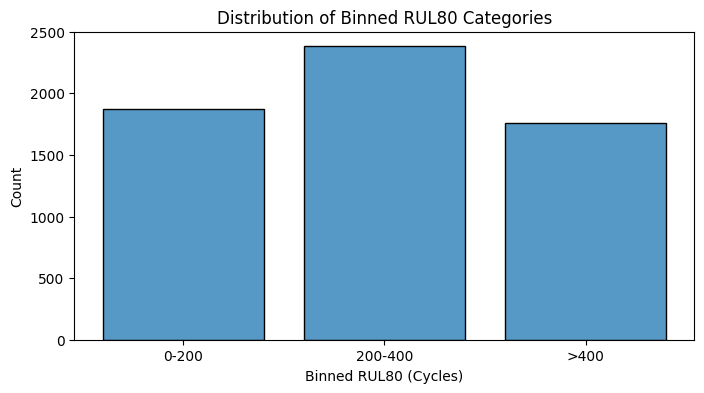

In [1]:
import pandas as pd
import numpy as np
import mat4py as mpy
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "Degradation_Prediction_Dataset_ISEA.mat"  # Adjust if needed
data_loader = mpy.loadmat(file_path)
df = pd.DataFrame.from_dict(data_loader["TDS"])

# Function to trim history arrays to the last 120 cycles
def trim_history(row, min_length=120):
    history_cap = np.array(row["History"])
    history_cycles = np.array(row["History_Cycle"])

    if len(history_cap) < min_length or len(history_cycles) < min_length:
        return pd.Series({"History": np.nan, "History_Cycle": np.nan})

    return pd.Series({
        "History": history_cap[-min_length:],  # Keep last 120 values
        "History_Cycle": history_cycles[-min_length:]  # Keep last 120 cycles
    })

# Apply trimming
df[["History", "History_Cycle"]] = df.apply(trim_history, axis=1)

# Drop NaN values (for sequences shorter than 120 cycles)
df = df.dropna(subset=["History"])

# Compute EOL80 and RUL80
def compute_eol_and_rul80(row):
    history_cap = np.array(row["History"])
    history_cycles = np.array(row["History_Cycle"])
    target_cap = np.array(row["Target_expanded"])
    target_cycles = np.array(row["Target_Cycle_Expanded"])

    eol80_cycle, rul80 = np.nan, np.nan
    if len(history_cap) == 0 or len(history_cycles) == 0:
        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})
    
    initial_capacity = history_cap[0]
    threshold = 0.8 * initial_capacity

    if history_cap[-1] <= threshold:
        return pd.Series({"EOL80": np.nan, "RUL80": np.nan})
    
    if len(target_cap) == 0 or len(target_cycles) == 0:
        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

    below_threshold_indices = np.where(target_cap < threshold)[0]
    if len(below_threshold_indices) > 0:
        eol80_index = below_threshold_indices[0]
        eol80_cycle = target_cycles[eol80_index]

    if not pd.isna(eol80_cycle):
        last_history_cycle = history_cycles[-1]
        rul80 = eol80_cycle - last_history_cycle

    return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

df[["EOL80", "RUL80"]] = df.apply(compute_eol_and_rul80, axis=1)

# Drop NaN values for RUL80 before binning
df_filtered = df.dropna(subset=["RUL80"])


# Define bins and labesl, but with categories starting from 0-200 and increasing by 200
bins = [0, 200, 400, np.inf]
labels = ["0-200", "200-400", ">400"]


# Apply binning
df_filtered["RUL80_binned"] = pd.cut(df_filtered["RUL80"], bins=bins, labels=labels, include_lowest=True)

# Plot histogram of binned RUL80 values
plt.figure(figsize=(8, 4))
sns.histplot(df_filtered["RUL80_binned"], discrete=True, shrink=0.8)
plt.xlabel("Binned RUL80 (Cycles)")
plt.ylabel("Count")
plt.title("Distribution of Binned RUL80 Categories")
plt.show()


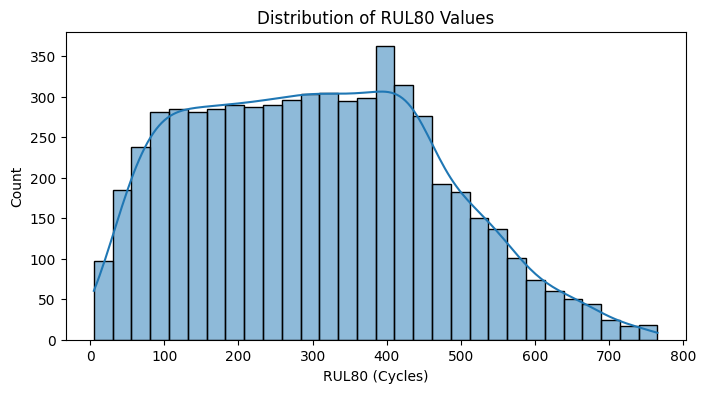

In [2]:
# Plot histogram of continuous RUL80 values
plt.figure(figsize=(8, 4))
sns.histplot(df_filtered["RUL80"], bins=30, kde=True)
plt.xlabel("RUL80 (Cycles)")
plt.ylabel("Count")
plt.title("Distribution of RUL80 Values")
plt.show()


In [3]:
import kerastuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical



# Ensure reproducibility
np.random.seed(None)
random.seed(None)
tf.random.set_seed(None)

labels = ["0-200", "200-400", ">400"]

# Set bins and labels
label_mapping = {label: i for i, label in enumerate(labels)}
df_filtered["RUL80_binned"] = df_filtered["RUL80_binned"].map(label_mapping)

# Prepare sequences
X = np.array(df_filtered["History"].tolist())  # Direct NumPy conversion (avoiding unnecessary padding)
y = np.array(df_filtered["RUL80_binned"])

# Normalize sequences
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=len(label_mapping))

# Train-test split ensuring entire cells are separated
unique_cells = df_filtered["Cell"].unique()
np.random.shuffle(unique_cells)
split_ratio = 0.8
split_index = int(len(unique_cells) * split_ratio)
train_cells = unique_cells[:split_index]
test_cells = unique_cells[split_index:]

df_train = df_filtered[df_filtered["Cell"].isin(train_cells)]
df_test = df_filtered[df_filtered["Cell"].isin(test_cells)]

X_train, X_test = np.array(df_train["History"].tolist()), np.array(df_test["History"].tolist())
y_train, y_test = np.array(df_train["RUL80_binned"]), np.array(df_test["RUL80_binned"])

# Normalize training/testing separately
X_train = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_mapping))
y_test = to_categorical(y_test, num_classes=len(label_mapping))

/var/folders/nn/4_r89tj92wd44cypgj5z6vkh0000gn/T/ipykernel_45943/3305826383.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt
/var/folders/nn/4_r89tj92wd44cypgj5z6vkh0000gn/T/ipykernel_45943/3305826383.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["RUL80_binned"] = df_filtered["RUL80_binned"].map(label_mapping)


In [4]:
import kerastuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


# Ensure reproducibility
np.random.seed(None)
random.seed(None)
tf.random.set_seed(None)

labels = ["0-200", "200-400", ">400"]

# Set bins and labels
label_mapping = {label: i for i, label in enumerate(labels)}
df_filtered["RUL80_binned"] = df_filtered["RUL80_binned"].map(label_mapping)

# Prepare sequences
X = np.array(df_filtered["History"].tolist())  # Direct NumPy conversion (avoiding unnecessary padding)
y = np.array(df_filtered["RUL80_binned"])

# Normalize sequences
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=len(label_mapping))

# Train-test split ensuring entire cells are separated
unique_cells = df_filtered["Cell"].unique()
np.random.shuffle(unique_cells)
split_ratio = 0.8
split_index = int(len(unique_cells) * split_ratio)
train_cells = unique_cells[:split_index]
test_cells = unique_cells[split_index:]

df_train = df_filtered[df_filtered["Cell"].isin(train_cells)]
df_test = df_filtered[df_filtered["Cell"].isin(test_cells)]

X_train, X_test = np.array(df_train["History"].tolist()), np.array(df_test["History"].tolist())
y_train, y_test = np.array(df_train["RUL80_binned"]), np.array(df_test["RUL80_binned"])

# Normalize training/testing separately
X_train = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_mapping))
y_test = to_categorical(y_test, num_classes=len(label_mapping))

# Define the model-building function for Keras Tuner with a third Conv layer
def build_model(hp):
    input_layer = Input(shape=(X_train.shape[1], 1))
    
    # First Conv Layer
    x = Conv1D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5, 7]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Second Conv Layer
    x = Conv1D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Third Conv Layer (New)
    x = Conv1D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=128, step=32),
        kernel_size=hp.Choice('conv3_kernel_size', values=[3, 5]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Dense Layer
    x = Flatten()(x)
    x = Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(x)
    
    # Dropout Layer
    x = Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1))(x)
    
    # Output Layer
    output_layer = Dense(len(label_mapping), activation='softmax')(x)

    # Learning Rate Tuning
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compile Model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Initialize Keras Tuner for hyperparameter search with the updated model
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='tuner_results',
    project_name='cnn_rul_tuning_with_third_layer'
)

# Display the search space summary
tuner.search_space_summary()

# Run the tuner search with increased epochs and early stopping patience
tuner.search(
    X_train, y_train,
    epochs=100,  # Increased from 50 to 100 epochs
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)]
)

# Display the best hyperparameters after tuning
tuner.results_summary()


/var/folders/nn/4_r89tj92wd44cypgj5z6vkh0000gn/T/ipykernel_45943/2731678857.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["RUL80_binned"] = df_filtered["RUL80_binned"].map(label_mapping)
/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/keras/src/utils/numerical_utils.py:87: RuntimeWarning: invalid value encountered in cast
  x = np.array(x, dtype="int64")
/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/keras/src/utils/numerical_utils.py:87: RuntimeWarning: invalid value encountered in cast
  x = np.array(x, dtype="int64")


Search space summary
Default search space size: 10
conv1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv1_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
l2_reg (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005, 0.0001], 'ordered': True}
conv2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv2_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv3_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.3, 'conditions': [], 'mi

KeyboardInterrupt: 

In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display best hyperparameters (for confirmation)
print(f"""
Best Hyperparameters:
- conv1_filters: {best_hps.get('conv1_filters')}
- conv1_kernel_size: {best_hps.get('conv1_kernel_size')}
- l2_reg: {best_hps.get('l2_reg')}
- conv2_filters: {best_hps.get('conv2_filters')}
- conv2_kernel_size: {best_hps.get('conv2_kernel_size')}
- dense_units: {best_hps.get('dense_units')}
- dropout_rate: {best_hps.get('dropout_rate')}
- learning_rate: {best_hps.get('learning_rate')}
""")


In [ ]:
best_hps

In [14]:
best_hps = {
    'conv1_filters': 32,
    'conv1_kernel_size': 7,
    'l2_reg': 0.0005,
    'conv2_filters': 32,
    'conv2_kernel_size': 5,
    'dense_units': 256,
    'dropout_rate': 0.4,
    'learning_rate': 0.0001
}

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def build_model_from_hps(hps):
    input_layer = Input(shape=(X_train.shape[1], 1))
    
    # First Conv Layer
    x = Conv1D(
        filters=hps['conv1_filters'],
        kernel_size=hps['conv1_kernel_size'],
        activation='relu',
        kernel_regularizer=l2(hps['l2_reg'])
    )(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Second Conv Layer
    x = Conv1D(
        filters=hps['conv2_filters'],
        kernel_size=hps['conv2_kernel_size'],
        activation='relu',
        kernel_regularizer=l2(hps['l2_reg'])
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Dense Layer
    x = Flatten()(x)
    x = Dense(
        units=hps['dense_units'],
        activation='relu',
        kernel_regularizer=l2(hps['l2_reg'])
    )(x)
    
    # Dropout Layer
    x = Dropout(rate=hps['dropout_rate'])(x)
    
    # Output Layer
    output_layer = Dense(len(label_mapping), activation='softmax')(x)
    
    # Compile Model
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(learning_rate=hps['learning_rate'])
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:

# Build the model
model = build_model_from_hps(best_hps)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,  # You can adjust epochs as needed
    batch_size=8,
    validation_data=(X_test, y_test))



# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Ensure consistent labels even if some classes are missing in y_true/y_pred
all_labels = np.arange(len(labels))  # [0, 1, 2, 3, 4]

# Classification report
print(classification_report(y_true, y_pred, labels=all_labels, target_names=labels, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=all_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import random

# Ensure reproducibility
np.random.seed(None)
random.seed(None)
tf.random.set_seed(None)

labels = ["0-200", "200-400", ">400"]

# Set bins and labels
label_mapping = {label: i for i, label in enumerate(labels)}
df_filtered["RUL80_binned"] = df_filtered["RUL80_binned"].map(label_mapping)

# Prepare sequences
X = np.array(df_filtered["History"].tolist())  # Direct NumPy conversion (avoiding unnecessary padding)
y = np.array(df_filtered["RUL80_binned"])

# Normalize sequences
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=len(label_mapping))

# Train-test split ensuring entire cells are separated
unique_cells = df_filtered["Cell"].unique()
np.random.shuffle(unique_cells)
split_ratio = 0.8
split_index = int(len(unique_cells) * split_ratio)
train_cells = unique_cells[:split_index]
test_cells = unique_cells[split_index:]

df_train = df_filtered[df_filtered["Cell"].isin(train_cells)]
df_test = df_filtered[df_filtered["Cell"].isin(test_cells)]

X_train, X_test = np.array(df_train["History"].tolist()), np.array(df_test["History"].tolist())
y_train, y_test = np.array(df_train["RUL80_binned"]), np.array(df_test["RUL80_binned"])

# Normalize training/testing separately
X_train = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_mapping))
y_test = to_categorical(y_test, num_classes=len(label_mapping))

# Compute class weights for imbalance handling
#class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
#class_weight_dict = dict(enumerate(class_weights))

# Define CNN model
input_layer = Input(shape=(X_train.shape[1], 1))
x = Conv1D(filters=32, kernel_size=5, activation="relu", kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Flatten()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.6)(x)  # Increased dropout to reduce overfitting
output_layer = Dense(len(label_mapping), activation="softmax")(x)

# Create Model
model = Model(inputs=input_layer, outputs=output_layer)

# Use an ExponentialDecay schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


# Remove ReduceLROnPlateau
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_data=(X_test, y_test),
    #class_weight=class_weight_dict,  # Handle class imbalance
    #callbacks=[early_stopping]  # Only early stopping
)



# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Ensure consistent labels even if some classes are missing in y_true/y_pred
all_labels = np.arange(len(labels))  # [0, 1, 2, 3, 4]

# Classification report
print(classification_report(y_true, y_pred, labels=all_labels, target_names=labels, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=all_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def grad_cam_1d(model, input_sequence, class_index, conv_layer_name="conv1d_2"):
    """
    Computes Grad-CAM heatmap for 1D convolutional layers.
    """
    # Ensure input has batch and channel dimensions
    input_sequence = np.expand_dims(input_sequence, axis=(0, -1))  # (1, time_steps, 1)
    input_sequence = tf.convert_to_tensor(input_sequence, dtype=tf.float32)

    # Get target convolutional layer
    conv_layer = model.get_layer(conv_layer_name)

    # Create model to extract feature maps and predictions
    grad_model = Model(inputs=model.input, outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        tape.watch(input_sequence)
        conv_output, predictions = grad_model(input_sequence)
        class_score = predictions[:, class_index]

    # Compute gradients of the class score w.r.t. convolutional output
    grads = tape.gradient(class_score, conv_output)
    if grads is None or np.isnan(grads.numpy()).any():
        print("Warning: Gradients contain NaNs! Replacing with zeros.")
        grads = tf.zeros_like(conv_output)

    # Compute importance weights
    pooled_grads = tf.reduce_mean(grads, axis=1)

    # Apply weights to feature maps
    conv_output = conv_output[0]  # Remove batch dimension
    pooled_grads = pooled_grads[0]  # Remove batch dimension for weights
    heatmap = tf.reduce_sum(conv_output * pooled_grads, axis=-1).numpy()

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-6)

    # Interpolate heatmap to match input sequence length
    input_seq_len = input_sequence.shape[1]
    heatmap_len = len(heatmap)

    if heatmap_len != input_seq_len:
        heatmap_rescaled = np.interp(
            np.arange(input_seq_len),
            np.linspace(0, input_seq_len - 1, heatmap_len),  # Map heatmap length to input length
            heatmap
        )
    else:
        heatmap_rescaled = heatmap  # No interpolation needed if lengths match
    
    return heatmap_rescaled


# Run Grad-CAM on random samples
for i in range(4):
    sample_idx = np.random.randint(len(X_test))
    input_seq = X_test[sample_idx]
    true_label = np.argmax(y_test[sample_idx])

    heatmap = grad_cam_1d(model, input_seq, class_index=true_label)

    # Plot results
    plt.figure(figsize=(12, 4))
    plt.plot(input_seq, label="Input Sequence", alpha=0.6)
    plt.plot(heatmap, label="Grad-CAM Heatmap", linewidth=2)
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Value")
    plt.title(f"Grad-CAM for Class {true_label}")
    plt.legend()
    plt.show()


In [ ]:
def plot_grad_cam_for_all_classes(model, input_sequence, true_label, class_labels, conv_layer_name="conv1d_2"):
    """
    Plots Grad-CAM heatmaps for all classes for a given input sequence.

    Args:
        model: Trained Keras model.
        input_sequence: 1D input array.
        true_label: The true class label index.
        class_labels: List of class names.
        conv_layer_name: Name of the convolutional layer for Grad-CAM.
    """
    num_classes = len(class_labels)
    plt.figure(figsize=(15, 3 * num_classes))

    for class_idx in range(num_classes):
        # Compute Grad-CAM heatmap for each class
        heatmap = grad_cam_1d(model, input_sequence, class_index=class_idx, conv_layer_name=conv_layer_name)

        # Plot input sequence and corresponding Grad-CAM heatmap
        plt.subplot(num_classes, 1, class_idx + 1)
        plt.plot(input_sequence.squeeze(), label="Input Sequence", alpha=0.6)
        plt.plot(heatmap, label=f"Grad-CAM: {class_labels[class_idx]}", linewidth=2)
        
        if class_idx == true_label:
            plt.title(f"Class {class_labels[class_idx]} (True Label)", color='green', fontsize=12)
        else:
            plt.title(f"Class {class_labels[class_idx]}", fontsize=12)
            
        plt.xlabel("Time Step")
        plt.ylabel("Activation")
        plt.legend()

    plt.tight_layout()
    plt.show()


# Run Grad-CAM for all classes on a random sample
sample_idx = np.random.randint(len(X_test))
input_seq = X_test[sample_idx]
true_label = np.argmax(y_test[sample_idx])

plot_grad_cam_for_all_classes(model, input_seq, true_label, labels)


In [ ]:
def plot_grad_cam_for_all_classes_misclassified(model, X_test, y_test, class_labels, conv_layer_name="conv1d_2"):
    """
    Finds a misclassified sample and plots Grad-CAM heatmaps for all classes.

    Args:
        model: Trained Keras model.
        X_test: Test data (input sequences).
        y_test: True labels (one-hot encoded).
        class_labels: List of class names.
        conv_layer_name: Name of the convolutional layer for Grad-CAM.
    """
    # Get model predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Find indices of misclassified samples
    misclassified_indices = np.where(y_pred != y_true)[0]

    if len(misclassified_indices) == 0:
        print("No misclassified samples found!")
        return

    # Select a random misclassified sample
    sample_idx = np.random.choice(misclassified_indices)
    input_seq = X_test[sample_idx]
    true_label = y_true[sample_idx]
    predicted_label = y_pred[sample_idx]

    print(f"Selected Misclassified Sample Index: {sample_idx}")
    print(f"True Label: {class_labels[true_label]}")
    print(f"Predicted Label: {class_labels[predicted_label]}")

    # Plot Grad-CAM for all classes
    num_classes = len(class_labels)
    plt.figure(figsize=(15, 3 * num_classes))

    for class_idx in range(num_classes):
        heatmap = grad_cam_1d(model, input_seq, class_index=class_idx, conv_layer_name=conv_layer_name)

        plt.subplot(num_classes, 1, class_idx + 1)
        plt.plot(input_seq.squeeze(), label="Input Sequence", alpha=0.6)
        plt.plot(heatmap, label=f"Grad-CAM: {class_labels[class_idx]}", linewidth=2)

        # Highlight true and predicted labels
        if class_idx == true_label:
            plt.title(f"Class {class_labels[class_idx]} (True Label)", color='green', fontsize=12)
        elif class_idx == predicted_label:
            plt.title(f"Class {class_labels[class_idx]} (Predicted Label)", color='red', fontsize=12)
        else:
            plt.title(f"Class {class_labels[class_idx]}", fontsize=12)

        plt.xlabel("Time Step")
        plt.ylabel("Activation")
        plt.legend()

    plt.tight_layout()
    plt.show()


# Run Grad-CAM visualization for a misclassified sample
plot_grad_cam_for_all_classes_misclassified(model, X_test, y_test, labels)


In [15]:
import pandas as pd
import numpy as np
import mat4py as mpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the Aachen dataset
def preprocess_aachen_dataset(
    file_path,
    test_cell_count=3,
    random_state=42,
):
    """
    Preprocess the Aachen dataset for CNN training, with optional phase filtering
    and optional log transform of the target values (RUL80).
    """
    data_loader = mpy.loadmat(file_path)
    df = pd.DataFrame.from_dict(data_loader["TDS"])

    # Filter to where the last cycle in history is 600
    df = df[df["History_Cycle"].apply(lambda x: x[-1]) == 600]

    # Compute EOL80 and RUL80 if missing
    def compute_eol_and_rul80(row):
        history_cap = np.array(row["History"])
        history_cycles = np.array(row["History_Cycle"])
        target_cap = np.array(row["Target_expanded"])
        target_cycles = np.array(row["Target_Cycle_Expanded"])

        eol80_cycle, rul80 = np.nan, np.nan
        if len(history_cap) == 0 or len(history_cycles) == 0:
            return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})
        
        initial_capacity = history_cap[0]
        threshold = 0.8 * initial_capacity

        if history_cap[-1] <= threshold:
            return pd.Series({"EOL80": np.nan, "RUL80": np.nan})
        
        if len(target_cap) == 0 or len(target_cycles) == 0:
            return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

        below_threshold_indices = np.where(target_cap < threshold)[0]
        if len(below_threshold_indices) > 0:
            eol80_index = below_threshold_indices[0]
            eol80_cycle = target_cycles[eol80_index]

        if not pd.isna(eol80_cycle):
            last_history_cycle = history_cycles[-1]
            rul80 = eol80_cycle - last_history_cycle

        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

    df[["EOL80", "RUL80"]] = df.apply(compute_eol_and_rul80, axis=1)

    # Extract sequence lengths for analysis
    df["Sequence_Length"] = df["History"].apply(len)
    
    # Train-test split
    cells_to_hold_back = df["Cell"].unique()[:test_cell_count]
    df_test = df[df["Cell"].isin(cells_to_hold_back)]
    df_train_val = df[~df["Cell"].isin(cells_to_hold_back)]

    df_train, df_val = train_test_split(
        df_train_val, test_size=0.2, random_state=random_state
    )

    history_train = df_train["History"].tolist()
    history_val = df_val["History"].tolist()
    history_test = df_test["History"].tolist()

    y_train = np.array(df_train["RUL80"])
    y_val = np.array(df_val["RUL80"])
    y_test = np.array(df_test["RUL80"])
    
    scaler = MinMaxScaler()
    all_histories = history_train + history_val + history_test
    all_histories_flat = np.concatenate(all_histories)
    scaler.fit(all_histories_flat.reshape(-1, 1))

    history_train_norm = [scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in history_train]
    history_val_norm = [scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in history_val]
    history_test_norm = [scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in history_test]
    
    return {
        "X_train": history_train_norm,
        "X_val": history_val_norm,
        "X_test": history_test_norm,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test
    }

# Load data
file_path = "Degradation_Prediction_Dataset_ISEA.mat"
data = preprocess_aachen_dataset(file_path)




In [ ]:
# Plot the distribution of sequence lengths
plt.figure(figsize=(12, 6))
sns.histplot([len(seq) for seq in data["X_train"]], bins=20, kde=True)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Sequence Lengths in X_train")
plt.show()


In [17]:
#

In [ ]:
import pandas as pd
import numpy as np
import mat4py as mpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the Aachen dataset
def preprocess_aachen_dataset(
    file_path,
    test_cell_count=3,
    random_state=42,
):
    """
    Preprocess the Aachen dataset for CNN training, with optional phase filtering
    and optional log transform of the target values (RUL80).
    """
    data_loader = mpy.loadmat(file_path)
    df = pd.DataFrame.from_dict(data_loader["TDS"])

    # Filter to where the last cycle in history is 600
    df = df[df["History_Cycle"].apply(lambda x: x[-1]) == 600]

    # Compute EOL80 and RUL80 if missing
    def compute_eol_and_rul80(row):
        history_cap = np.array(row["History"])
        history_cycles = np.array(row["History_Cycle"])
        target_cap = np.array(row["Target_expanded"])
        target_cycles = np.array(row["Target_Cycle_Expanded"])

        eol80_cycle, rul80 = np.nan, np.nan
        if len(history_cap) == 0 or len(history_cycles) == 0:
            return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})
        
        initial_capacity = history_cap[0]
        threshold = 0.8 * initial_capacity

        if history_cap[-1] <= threshold:
            return pd.Series({"EOL80": np.nan, "RUL80": np.nan})
        
        if len(target_cap) == 0 or len(target_cycles) == 0:
            return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

        below_threshold_indices = np.where(target_cap < threshold)[0]
        if len(below_threshold_indices) > 0:
            eol80_index = below_threshold_indices[0]
            eol80_cycle = target_cycles[eol80_index]

        if not pd.isna(eol80_cycle):
            last_history_cycle = history_cycles[-1]
            rul80 = eol80_cycle - last_history_cycle

        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

    df[["EOL80", "RUL80"]] = df.apply(compute_eol_and_rul80, axis=1)

    # Extract sequence lengths for analysis
    df["Sequence_Length"] = df["History"].apply(len)
    
    # Bin the RUL80 values into two categories
    bins = [0, 600, np.inf]
    labels = [0, 1]  # Categories for bins
    df["RUL80_binned"] = pd.cut(df["RUL80"], bins=bins, labels=labels, include_lowest=True)
    
    # Train-test split
    cells_to_hold_back = df["Cell"].unique()[:test_cell_count]
    df_test = df[df["Cell"].isin(cells_to_hold_back)]
    df_train_val = df[~df["Cell"].isin(cells_to_hold_back)]

    df_train, df_val = train_test_split(
        df_train_val, test_size=0.2, random_state=random_state
    )

    history_train = df_train["History"].tolist()
    history_val = df_val["History"].tolist()
    history_test = df_test["History"].tolist()

    y_train = np.array(df_train["RUL80_binned"].astype(int))
    y_val = np.array(df_val["RUL80_binned"].astype(int))
    y_test = np.array(df_test["RUL80_binned"].astype(int))
    
    scaler = MinMaxScaler()
    all_histories = history_train + history_val + history_test
    all_histories_flat = np.concatenate(all_histories)
    scaler.fit(all_histories_flat.reshape(-1, 1))

    history_train_norm = [scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in history_train]
    history_val_norm = [scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in history_val]
    history_test_norm = [scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in history_test]
    
    return {
        "X_train": history_train_norm,
        "X_val": history_val_norm,
        "X_test": history_test_norm,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test
    }

# Load data
file_path = "Degradation_Prediction_Dataset_ISEA.mat"
data = preprocess_aachen_dataset(file_path)

# Plot all sequences in training data
plt.figure(figsize=(12, 6))
for seq in data["X_train"]:
    plt.plot(seq, alpha=0.3)
plt.xlabel("Time Step")
plt.ylabel("Normalized Capacity")
plt.title("All Training Sequences")
plt.show()

# Plot histogram of sequence lengths
sequence_lengths = [len(seq) for seq in data["X_train"]]
plt.figure(figsize=(8, 4))
sns.histplot(sequence_lengths, bins=20, kde=True)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Sequence Lengths in Dataset")
plt.show()

# Plot distribution of binned RUL values
plt.figure(figsize=(8, 4))
sns.histplot(data["y_train"], bins=2, discrete=True)
plt.xlabel("RUL Bin")
plt.ylabel("Count")
plt.title("Distribution of Binned RUL Values in Training Set")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import mat4py as mpy
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "Degradation_Prediction_Dataset_ISEA.mat"  # Adjust if needed
data_loader = mpy.loadmat(file_path)
df = pd.DataFrame.from_dict(data_loader["TDS"])

# Filter to where the last cycle in history is exactly 600
df = df[df["History_Cycle"].apply(lambda x: x[-1]) == 600]

# Compute EOL80 and RUL80 if missing
def compute_eol_and_rul80(row):
    history_cap = np.array(row["History"])
    history_cycles = np.array(row["History_Cycle"])
    target_cap = np.array(row["Target_expanded"])
    target_cycles = np.array(row["Target_Cycle_Expanded"])

    eol80_cycle, rul80 = np.nan, np.nan
    if len(history_cap) == 0 or len(history_cycles) == 0:
        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})
    
    initial_capacity = history_cap[0]
    threshold = 0.8 * initial_capacity

    if history_cap[-1] <= threshold:
        return pd.Series({"EOL80": np.nan, "RUL80": np.nan})
    
    if len(target_cap) == 0 or len(target_cycles) == 0:
        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

    below_threshold_indices = np.where(target_cap < threshold)[0]
    if len(below_threshold_indices) > 0:
        eol80_index = below_threshold_indices[0]
        eol80_cycle = target_cycles[eol80_index]

    if not pd.isna(eol80_cycle):
        last_history_cycle = history_cycles[-1]
        rul80 = eol80_cycle - last_history_cycle

    return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

df[["EOL80", "RUL80"]] = df.apply(compute_eol_and_rul80, axis=1)

# Drop NaN values for RUL80 before binning
df_filtered = df.dropna(subset=["RUL80"])

# Define bins and labels
bins = [0, 400, 500, 600, np.inf]
labels = ["<400", "400-500", "500-600", ">600"]

# Apply binning
df_filtered["RUL80_binned"] = pd.cut(df_filtered["RUL80"], bins=bins, labels=labels, include_lowest=True)

# Plot histogram of binned RUL80 values
plt.figure(figsize=(8, 4))
sns.histplot(df_filtered["RUL80_binned"], discrete=True, shrink=0.8)
plt.xlabel("Binned RUL80 (Cycles)")
plt.ylabel("Count")
plt.title("Distribution of Binned RUL80 Categories")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler



import random

np.random.seed(None)  # Ensures different results across script executions
random.seed(None)  # Also resets Python’s built-in random module
tf.random.set_seed(None)  # Ensures different TensorFlow random operations


# Convert RUL bins to integer labels
label_mapping = {"<400": 0, "400-500": 1, "500-600": 2, ">600": 3}
df_filtered["RUL80_binned"] = df_filtered["RUL80_binned"].map(label_mapping)

# Prepare history sequences
X = df_filtered["History"].tolist()
y = np.array(df_filtered["RUL80_binned"])

# Pad sequences to the same length
max_seq_length = max(len(seq) for seq in X)
X_padded = pad_sequences(X, maxlen=max_seq_length, padding='post', dtype="float32")

# Normalize the sequences
scaler = MinMaxScaler()
X_padded = scaler.fit_transform(X_padded.reshape(-1, 1)).reshape(X_padded.shape)

# Debug: Check for NaNs in input
print("Max input value:", np.max(X_padded))
print("Min input value:", np.min(X_padded))
print("Any NaNs?:", np.isnan(X_padded).any())

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=4)

# Train-test split ensuring entire cells are separated
unique_cells = df_filtered["Cell"].unique()
np.random.shuffle(unique_cells)
split_ratio = 0.8
split_index = int(len(unique_cells) * split_ratio)
train_cells = unique_cells[:split_index]
test_cells = unique_cells[split_index:]

df_train = df_filtered[df_filtered["Cell"].isin(train_cells)]
df_test = df_filtered[df_filtered["Cell"].isin(test_cells)]

X_train, X_test = df_train["History"].tolist(), df_test["History"].tolist()
y_train, y_test = np.array(df_train["RUL80_binned"]), np.array(df_test["RUL80_binned"])

# Pad and normalize new splits
X_train = pad_sequences(X_train, maxlen=max_seq_length, padding='post', dtype="float32")
X_test = pad_sequences(X_test, maxlen=max_seq_length, padding='post', dtype="float32")
X_train = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Define CNN model
input_layer = Input(shape=(max_seq_length, 1))
x = Conv1D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001), name="conv1d_1")(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001), name="conv1d_2")(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="softmax")(x)  # Changed back to softmax

# Create Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with lower learning rate and gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, clipnorm=1.0)  # Reduce LR
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test)
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

def grad_cam_1d(model, input_sequence, class_index, conv_layer_name="conv1d_2"):
    input_sequence = np.expand_dims(input_sequence, axis=0)  # Add batch dimension
    input_sequence = tf.convert_to_tensor(input_sequence, dtype=tf.float32)  # Convert to tensor
    
    conv_layer = model.get_layer(conv_layer_name)

    # Create model to extract activations & logits
    grad_model = Model(inputs=model.input, outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        tape.watch(input_sequence)
        conv_output, predictions = grad_model(input_sequence)
        predicted_class = predictions[:, class_index]  # Use logits instead of softmax

    grads = tape.gradient(predicted_class, conv_output)

    if grads is None or np.isnan(grads.numpy()).any():
        print("Warning: Gradients contain NaNs! Replacing with zeros.")
        grads = tf.zeros_like(conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))  # Mean over time and filters
    conv_output = conv_output[0]  # Remove batch dimension

    # Weighted sum of activations
    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1).numpy()

    # Normalize heatmap
    heatmap -= np.min(heatmap)
    heatmap /= (np.max(heatmap) + 1e-6)

    # Rescale to match input sequence length
    heatmap_rescaled = np.interp(np.arange(len(input_sequence.numpy().flatten())), 
                                 np.linspace(0, len(input_sequence.numpy().flatten()) - 1, len(heatmap)), 
                                 heatmap)
    
    return heatmap_rescaled







for i in range(4):
    sample_idx = np.random.randint(len(X_test))
    input_seq = X_test[sample_idx]
    true_label = np.argmax(y_test[sample_idx])

    heatmap = grad_cam_1d(model, input_seq, class_index=true_label)

    print(heatmap)

    plt.figure(figsize=(12, 4))
    plt.plot(input_seq, label="Input Sequence", alpha=0.6)
    plt.plot(heatmap, label="Grad-CAM Heatmap", linewidth=2)
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Value")
    plt.title(f"Grad-CAM for Class {true_label}")
    plt.legend()
    plt.show()



In [ ]:
heatmap

In [ ]:
print("Heatmap min:", np.min(heatmap))
print("Heatmap max:", np.max(heatmap))


In [ ]:
import pandas as pd
import numpy as np
import mat4py as mpy
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "Degradation_Prediction_Dataset_ISEA.mat"  # Adjust if needed
data_loader = mpy.loadmat(file_path)
df = pd.DataFrame.from_dict(data_loader["TDS"])

# Function to trim history arrays to the last 120 cycles
def trim_history(row, min_length=120):
    history_cap = np.array(row["History"])
    history_cycles = np.array(row["History_Cycle"])

    if len(history_cap) < min_length or len(history_cycles) < min_length:
        return pd.Series({"History": np.nan, "History_Cycle": np.nan})

    return pd.Series({
        "History": history_cap[-min_length:],  # Keep last 120 values
        "History_Cycle": history_cycles[-min_length:]  # Keep last 120 cycles
    })

# Apply trimming
df[["History", "History_Cycle"]] = df.apply(trim_history, axis=1)

# Drop NaN values (for sequences shorter than 120 cycles)
df = df.dropna(subset=["History"])

# Compute EOL80 and RUL80
def compute_eol_and_rul80(row):
    history_cap = np.array(row["History"])
    history_cycles = np.array(row["History_Cycle"])
    target_cap = np.array(row["Target_expanded"])
    target_cycles = np.array(row["Target_Cycle_Expanded"])

    eol80_cycle, rul80 = np.nan, np.nan
    if len(history_cap) == 0 or len(history_cycles) == 0:
        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})
    
    initial_capacity = history_cap[0]
    threshold = 0.8 * initial_capacity

    if history_cap[-1] <= threshold:
        return pd.Series({"EOL80": np.nan, "RUL80": np.nan})
    
    if len(target_cap) == 0 or len(target_cycles) == 0:
        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

    below_threshold_indices = np.where(target_cap < threshold)[0]
    if len(below_threshold_indices) > 0:
        eol80_index = below_threshold_indices[0]
        eol80_cycle = target_cycles[eol80_index]

    if not pd.isna(eol80_cycle):
        last_history_cycle = history_cycles[-1]
        rul80 = eol80_cycle - last_history_cycle

    return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

df[["EOL80", "RUL80"]] = df.apply(compute_eol_and_rul80, axis=1)

# Drop NaN values for RUL80 before binning
df_filtered = df.dropna(subset=["RUL80"])

# Define bins and labels
bins = [0, 400, 500, 600, np.inf]
labels = ["<400", "400-500", "500-600", ">600"]

# Define bins and labesl, but with categories starting from 0-100 and increasing by 100
bins = [0, 100, 200, 300, 400, 500, 600, np.inf]
labels = ["0-100", "100-200", "200-300", "300-400", "400-500", "500-600", ">600"]


# Apply binning
df_filtered["RUL80_binned"] = pd.cut(df_filtered["RUL80"], bins=bins, labels=labels, include_lowest=True)

# Plot histogram of binned RUL80 values
plt.figure(figsize=(8, 4))
sns.histplot(df_filtered["RUL80_binned"], discrete=True, shrink=0.8)
plt.xlabel("Binned RUL80 (Cycles)")
plt.ylabel("Count")
plt.title("Distribution of Binned RUL80 Categories")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler



import random

np.random.seed(None)  # Ensures different results across script executions
random.seed(None)  # Also resets Python’s built-in random module
tf.random.set_seed(None)  # Ensures different TensorFlow random operations


# Convert RUL bins to integer labels
label_mapping = {"<400": 0, "400-500": 1, "500-600": 2, ">600": 3}
df_filtered["RUL80_binned"] = df_filtered["RUL80_binned"].map(label_mapping)

# Prepare history sequences
X = df_filtered["History"].tolist()
y = np.array(df_filtered["RUL80_binned"])

# Pad sequences to the same length
max_seq_length = max(len(seq) for seq in X)
X_padded = pad_sequences(X, maxlen=max_seq_length, padding='post', dtype="float32")

# Normalize the sequences
scaler = MinMaxScaler()
X_padded = scaler.fit_transform(X_padded.reshape(-1, 1)).reshape(X_padded.shape)

# Debug: Check for NaNs in input
print("Max input value:", np.max(X_padded))
print("Min input value:", np.min(X_padded))
print("Any NaNs?:", np.isnan(X_padded).any())

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=4)

# Train-test split ensuring entire cells are separated
unique_cells = df_filtered["Cell"].unique()
np.random.shuffle(unique_cells)
split_ratio = 0.8
split_index = int(len(unique_cells) * split_ratio)
train_cells = unique_cells[:split_index]
test_cells = unique_cells[split_index:]

df_train = df_filtered[df_filtered["Cell"].isin(train_cells)]
df_test = df_filtered[df_filtered["Cell"].isin(test_cells)]

X_train, X_test = df_train["History"].tolist(), df_test["History"].tolist()
y_train, y_test = np.array(df_train["RUL80_binned"]), np.array(df_test["RUL80_binned"])

# Pad and normalize new splits
X_train = pad_sequences(X_train, maxlen=max_seq_length, padding='post', dtype="float32")
X_test = pad_sequences(X_test, maxlen=max_seq_length, padding='post', dtype="float32")
X_train = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Define CNN model
input_layer = Input(shape=(max_seq_length, 1))
x = Conv1D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001), name="conv1d_1")(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001), name="conv1d_2")(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="softmax")(x)  # Changed back to softmax

# Create Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with lower learning rate and gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, clipnorm=1.0)  # Reduce LR
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test)
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

def grad_cam_1d(model, input_sequence, class_index, conv_layer_name="conv1d_2"):
    input_sequence = np.expand_dims(input_sequence, axis=0)  # Add batch dimension
    input_sequence = tf.convert_to_tensor(input_sequence, dtype=tf.float32)  # Convert to tensor
    
    conv_layer = model.get_layer(conv_layer_name)

    # Create model to extract activations & logits
    grad_model = Model(inputs=model.input, outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        tape.watch(input_sequence)
        conv_output, predictions = grad_model(input_sequence)
        predicted_class = predictions[:, class_index]  # Use logits instead of softmax

    grads = tape.gradient(predicted_class, conv_output)

    if grads is None or np.isnan(grads.numpy()).any():
        print("Warning: Gradients contain NaNs! Replacing with zeros.")
        grads = tf.zeros_like(conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))  # Mean over time and filters
    conv_output = conv_output[0]  # Remove batch dimension

    # Weighted sum of activations
    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1).numpy()

    # Normalize heatmap
    heatmap -= np.min(heatmap)
    heatmap /= (np.max(heatmap) + 1e-6)

    # Rescale to match input sequence length
    heatmap_rescaled = np.interp(np.arange(len(input_sequence.numpy().flatten())), 
                                 np.linspace(0, len(input_sequence.numpy().flatten()) - 1, len(heatmap)), 
                                 heatmap)
    
    return heatmap_rescaled







for i in range(4):
    sample_idx = np.random.randint(len(X_test))
    input_seq = X_test[sample_idx]
    true_label = np.argmax(y_test[sample_idx])

    heatmap = grad_cam_1d(model, input_seq, class_index=true_label)

    print(heatmap)

    plt.figure(figsize=(12, 4))
    plt.plot(input_seq, label="Input Sequence", alpha=0.6)
    plt.plot(heatmap, label="Grad-CAM Heatmap", linewidth=2)
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Value")
    plt.title(f"Grad-CAM for Class {true_label}")
    plt.legend()
    plt.show()



#Nytt forsøk

/var/folders/nn/4_r89tj92wd44cypgj5z6vkh0000gn/T/ipykernel_45943/845637574.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["RUL80_binned"] = pd.cut(df_filtered["RUL80"], bins=bins, labels=labels, include_lowest=True)


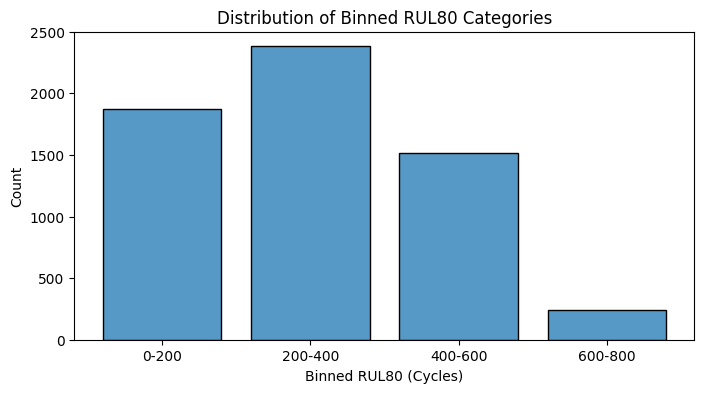

In [5]:
import pandas as pd
import numpy as np
import mat4py as mpy
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "Degradation_Prediction_Dataset_ISEA.mat"  # Adjust if needed
data_loader = mpy.loadmat(file_path)
df = pd.DataFrame.from_dict(data_loader["TDS"])

# Function to trim history arrays to the last 120 cycles
def trim_history(row, min_length=120):
    history_cap = np.array(row["History"])
    history_cycles = np.array(row["History_Cycle"])

    if len(history_cap) < min_length or len(history_cycles) < min_length:
        return pd.Series({"History": np.nan, "History_Cycle": np.nan})

    return pd.Series({
        "History": history_cap[-min_length:],  # Keep last 120 values
        "History_Cycle": history_cycles[-min_length:]  # Keep last 120 cycles
    })

# Apply trimming
df[["History", "History_Cycle"]] = df.apply(trim_history, axis=1)

# Drop NaN values (for sequences shorter than 120 cycles)
df = df.dropna(subset=["History"])

# Compute EOL80 and RUL80
def compute_eol_and_rul80(row):
    history_cap = np.array(row["History"])
    history_cycles = np.array(row["History_Cycle"])
    target_cap = np.array(row["Target_expanded"])
    target_cycles = np.array(row["Target_Cycle_Expanded"])

    eol80_cycle, rul80 = np.nan, np.nan
    if len(history_cap) == 0 or len(history_cycles) == 0:
        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})
    
    initial_capacity = history_cap[0]
    threshold = 0.8 * initial_capacity

    if history_cap[-1] <= threshold:
        return pd.Series({"EOL80": np.nan, "RUL80": np.nan})
    
    if len(target_cap) == 0 or len(target_cycles) == 0:
        return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

    below_threshold_indices = np.where(target_cap < threshold)[0]
    if len(below_threshold_indices) > 0:
        eol80_index = below_threshold_indices[0]
        eol80_cycle = target_cycles[eol80_index]

    if not pd.isna(eol80_cycle):
        last_history_cycle = history_cycles[-1]
        rul80 = eol80_cycle - last_history_cycle

    return pd.Series({"EOL80": eol80_cycle, "RUL80": rul80})

df[["EOL80", "RUL80"]] = df.apply(compute_eol_and_rul80, axis=1)

# Drop NaN values for RUL80 before binning
df_filtered = df.dropna(subset=["RUL80"])


# Define bins and labesl, but with categories starting from 0-200 and increasing by 200
bins = [0, 200, 400, 600, 800, np.inf]
labels = ["0-200", "200-400", "400-600", "600-800", ">800"]


# Apply binning
df_filtered["RUL80_binned"] = pd.cut(df_filtered["RUL80"], bins=bins, labels=labels, include_lowest=True)

# Plot histogram of binned RUL80 values
plt.figure(figsize=(8, 4))
sns.histplot(df_filtered["RUL80_binned"], discrete=True, shrink=0.8)
plt.xlabel("Binned RUL80 (Cycles)")
plt.ylabel("Count")
plt.title("Distribution of Binned RUL80 Categories")
plt.show()


In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
import random

# Ensure reproducibility
np.random.seed(None)
random.seed(None)
tf.random.set_seed(None)

labels = ["0-200", "200-400", "400-600", "600-800", ">800"]

# Set bins and labels
label_mapping = {label: i for i, label in enumerate(labels)}
df_filtered["RUL80_binned"] = df_filtered["RUL80_binned"].map(label_mapping)

# Update

# Prepare sequences
X = df_filtered["History"].tolist()
y = np.array(df_filtered["RUL80_binned"])

# Pad sequences
max_seq_length = 120  # Since history is trimmed to last 120 cycles
X_padded = pad_sequences(X, maxlen=max_seq_length, padding='post', dtype="float32")

# Normalize sequences
scaler = MinMaxScaler()
X_padded = scaler.fit_transform(X_padded.reshape(-1, 1)).reshape(X_padded.shape)

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=len(label_mapping))

# Train-test split ensuring entire cells are separated
unique_cells = df_filtered["Cell"].unique()
np.random.shuffle(unique_cells)
split_ratio = 0.8
split_index = int(len(unique_cells) * split_ratio)
train_cells = unique_cells[:split_index]
test_cells = unique_cells[split_index:]

df_train = df_filtered[df_filtered["Cell"].isin(train_cells)]
df_test = df_filtered[df_filtered["Cell"].isin(test_cells)]

X_train, X_test = df_train["History"].tolist(), df_test["History"].tolist()
y_train, y_test = np.array(df_train["RUL80_binned"]), np.array(df_test["RUL80_binned"])

# Pad and normalize
X_train = pad_sequences(X_train, maxlen=max_seq_length, padding='post', dtype="float32")
X_test = pad_sequences(X_test, maxlen=max_seq_length, padding='post', dtype="float32")
X_train = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_mapping))
y_test = to_categorical(y_test, num_classes=len(label_mapping))

# Define CNN model
input_layer = Input(shape=(max_seq_length, 1))
x = Conv1D(filters=32, kernel_size=5, activation="relu", kernel_regularizer=l2(0.001), name="conv1d_1")(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001), name="conv1d_2")(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(label_mapping), activation="softmax")(x)  # Adjusted for new categories

# Create Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with lower learning rate and gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test)
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/50


/var/folders/nn/4_r89tj92wd44cypgj5z6vkh0000gn/T/ipykernel_45943/1930579377.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["RUL80_binned"] = df_filtered["RUL80_binned"].map(label_mapping)


593/593 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6285 - loss: 1.2000 - val_accuracy: 0.4198 - val_loss: 1.8650
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7223 - loss: 0.7845 - val_accuracy: 0.6517 - val_loss: 1.1987
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7593 - loss: 0.6639 - val_accuracy: 0.6203 - val_loss: 1.2949
Epoch 4/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7596 - loss: 0.6401 - val_accuracy: 0.6195 - val_loss: 0.9447
Epoch 5/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7727 - loss: 0.5983 - val_accuracy: 0.6808 - val_loss: 0.8612
Epoch 6/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7696 - loss: 0.5937 - val_accuracy: 0.6502 - val_loss: 0.9599
Epoch 7/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7817 - loss: 0.5699 - val_accuracy: 0.6981 - val_loss: 0.7877
Epoch 8/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7843 - loss: 0.5575 - val_accuracy: 0.6942 - val_

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import random

# Ensure reproducibility
np.random.seed(None)
random.seed(None)
tf.random.set_seed(None)

labels = ["0-200", "200-400", "400-600", "600-800", ">800"]

# Set bins and labels
label_mapping = {label: i for i, label in enumerate(labels)}
df_filtered["RUL80_binned"] = df_filtered["RUL80_binned"].map(label_mapping)

# Prepare sequences
X = np.array(df_filtered["History"].tolist())  # Direct NumPy conversion (avoiding unnecessary padding)
y = np.array(df_filtered["RUL80_binned"])

# Normalize sequences
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=len(label_mapping))

# Train-test split ensuring entire cells are separated
unique_cells = df_filtered["Cell"].unique()
np.random.shuffle(unique_cells)
split_ratio = 0.8
split_index = int(len(unique_cells) * split_ratio)
train_cells = unique_cells[:split_index]
test_cells = unique_cells[split_index:]

df_train = df_filtered[df_filtered["Cell"].isin(train_cells)]
df_test = df_filtered[df_filtered["Cell"].isin(test_cells)]

X_train, X_test = np.array(df_train["History"].tolist()), np.array(df_test["History"].tolist())
y_train, y_test = np.array(df_train["RUL80_binned"]), np.array(df_test["RUL80_binned"])

# Normalize training/testing separately
X_train = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_mapping))
y_test = to_categorical(y_test, num_classes=len(label_mapping))

# Compute class weights for imbalance handling
#class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
#class_weight_dict = dict(enumerate(class_weights))

# Define CNN model
input_layer = Input(shape=(X_train.shape[1], 1))
x = Conv1D(filters=32, kernel_size=5, activation="relu", kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Flatten()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.6)(x)  # Increased dropout to reduce overfitting
output_layer = Dense(len(label_mapping), activation="softmax")(x)

# Create Model
model = Model(inputs=input_layer, outputs=output_layer)

# Use an ExponentialDecay schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


# Remove ReduceLROnPlateau
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_val ,y_val),
    #class_weight=class_weight_dict,  # Handle class imbalance
    #callbacks=[early_stopping]  # Only early stopping
)



# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


/var/folders/nn/4_r89tj92wd44cypgj5z6vkh0000gn/T/ipykernel_45943/3132690001.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["RUL80_binned"] = df_filtered["RUL80_binned"].map(label_mapping)
/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/keras/src/utils/numerical_utils.py:87: RuntimeWarning: invalid value encountered in cast
  x = np.array(x, dtype="int64")
/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/keras/src/utils/numerical_utils.py:87: RuntimeWarning: invalid value encountered in cast
  x = np.array(x, dtype="int64")


NameError: name 'X_val' is not defined

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def grad_cam_1d(model, input_sequence, class_index, conv_layer_name="conv1d_5"):
    """
    Computes Grad-CAM heatmap for 1D convolutional layers.

    Args:
        model: Trained Keras model.
        input_sequence: 1D input array.
        class_index: Target class index.
        conv_layer_name: Name of the convolutional layer for Grad-CAM.

    Returns:
        Heatmap aligned with input sequence length.
    """
    # Ensure input has batch and channel dimensions
    input_sequence = np.expand_dims(input_sequence, axis=(0, -1))  # Shape: (1, time_steps, 1)
    input_sequence = tf.convert_to_tensor(input_sequence, dtype=tf.float32)

    # Get target convolutional layer
    conv_layer = model.get_layer(conv_layer_name)

    # Create model to extract feature maps and predictions
    grad_model = Model(inputs=model.input, outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(input_sequence)
        class_score = predictions[:, class_index]  # Extract score for the target class

    # Compute gradients of the class score w.r.t. convolutional output
    grads = tape.gradient(class_score, conv_output)

    if grads is None or np.isnan(grads.numpy()).any():
        print("Warning: Gradients contain NaNs! Replacing with zeros.")
        grads = tf.zeros_like(conv_output)

    # Compute importance weights
    pooled_grads = tf.reduce_mean(grads, axis=1)  # Average over time dimension

    # Apply weights to feature maps
    conv_output = conv_output[0]  # Remove batch dimension
    pooled_grads = tf.expand_dims(pooled_grads, axis=0)  # Ensure broadcasting
    heatmap = tf.reduce_sum(conv_output * pooled_grads, axis=-1).numpy()

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)  # ReLU to remove negative values
    heatmap /= (np.max(heatmap) + 1e-6)  # Normalize to [0,1]

    # Fix shape issue in interpolation
    input_seq_len = input_sequence.shape[1]  # Get original sequence length
    heatmap_rescaled = np.interp(
        np.arange(input_seq_len),  # Ensure correct x-axis values
        np.linspace(0, input_seq_len - 1, len(heatmap)),  # Match original length
        heatmap.flatten()  # Ensure it's a 1D array
    )
    
    return heatmap_rescaled

# Run Grad-CAM on random samples
for i in range(4):
    sample_idx = np.random.randint(len(X_test))
    input_seq = X_test[sample_idx]
    true_label = np.argmax(y_test[sample_idx])

    heatmap = grad_cam_1d(model, input_seq, class_index=true_label)

    # Plot results
    plt.figure(figsize=(12, 4))
    plt.plot(input_seq, label="Input Sequence", alpha=0.6)
    plt.plot(heatmap, label="Grad-CAM Heatmap", linewidth=2)
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Value")
    plt.title(f"Grad-CAM for Class {true_label}")
    plt.legend()
    plt.show()


ValueError: fp and xp are not of the same length.